# PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões
Análise e classificação com a base de dados [Adult](https://www.kaggle.com/c/adult-pmr3508), disponível também em [UCI Repository](https://archive.ics.uci.edu/ml/index.php).

Autor: Lucas Tonini Rosenberg Schneider

---

## 1 Inicialização

### 1.1 Importando pacotes necessários

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing as prep

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

%matplotlib inline

### 1.2 Leitura dos dados

In [2]:
x_columns = ['ID', 'Age', 'Workclass', 'Final Weight', 'Education', 'Education Num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per Week', 'Native Country']
y_column = ['Income']

train_data_raw = pd.read_csv('data/train_data.csv', names = (x_columns + y_column), na_values = '?', header = 0)
test_data_raw = pd.read_csv('data/test_data.csv', names = x_columns, na_values = '?', header = 0)

In [3]:
print(train_data_raw.shape)
train_data_raw.head()

(32560, 16)


,ID,Age,Workclass,Final Weight,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per Week,Native Country,Income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


---

## 2 Análise e compreensão

### 2.1 Dados Numéricos

A seguir, serão discutidos os dados numéricos mais relevantes, cuja compreensão ajuda a entender melhor o problema

In [4]:
numeric_columns = list(train_data_raw.select_dtypes(include = np.number).columns)
train_data_raw[numeric_columns].describe()

,ID,Age,Final Weight,Education Num,Capital Gain,Capital Loss,Hours per Week
count,32560.000000,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,32559.500000,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,9399.406719,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,16280.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,24419.750000,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,32559.500000,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,40699.250000,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,48839.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
#sns.set()
#sns.pairplot(train_data_raw, vars = ['Age'], hue = 'Income')

In [5]:
def plot_feature_frequencies(data, feature):
    '''
    Plot frequencie for income <=50k and >50k for a specific feature
    '''
    
    less_50 = data.loc[data['Income'] == '<=50K', feature].value_counts().rename('<=50K')
    more_50 = data.loc[data['Income'] == '>50K', feature].value_counts().rename('>50K')
    plot_data = pd.concat([less_50, more_50], axis=1).dropna()
    plot_data.plot(xlabel = feature, ylabel = 'Frequency')

#### 2.1.1 ID

Essa feature contém apenas um número de identificação, ou seja, não é uma feature que faça sentido analisar, e, por isso, será removida durante o tratamento dos dados.

#### 2.1.2 Age

In [ ]:
age_data = plot_feature_frequencies(train_data_raw, 'Age')
#age_data.plot(xlabel = 'Age', ylabel = 'Frequency')

É possível ver claramente como a proporção de pessoas que ganham mais que 50 mil aumenta drásticamente com a idade. Entre 20 e 40 anos, há um crescimento acelerado, e a partir daí, a proporção se mantém mais estável.

#### 2.1.3 Final Weight

In [ ]:
plot_feature_frequencies(train_data_raw, 'Final Weight')


#### 2.1.4 Education Num

In [ ]:
plot_feature_frequencies(train_data_raw, 'Education Num')

Há dois pontos principais mostrados aqui: primeiramente, todos os indivíduos que ganhavam mais que 50k tem nível de escolaridade maior que 8, ou seja, pelo menos um diploma no nível técnico. Além disso, apenas a partir do nível 14, ou seja, a partir do bacharelado, a propórção de indivíduos que ganahvam mais que 50k superou a dos que ganahvam menos. Logo, grau de escolaridade seria um fator importante para fazer predições em relação à renda.

#### 2.1.5 Capital Gain

In [ ]:
plot_feature_frequencies(train_data_raw, 'Capital Gain')

#### 2.1.6 Capital Loss

In [ ]:
plot_feature_frequencies(train_data_raw, 'Capital Loss')

#### 2.1.7 Hours per Week

In [ ]:
plot_feature_frequencies(train_data_raw, 'Hours per Week')

Com esse gráfico percebe-se claramente que a maior parte das pessoas possui a jornada padrão de 40h por semana. Porém, quanto mais aumenta-se o número de horas trabalhadas, maior é a proporção de pessoas que ganham mais que 50k, enquanto para valores menores que 40h, a quantidade é bem pequena.

### 2.2 Dados categóricos

In [6]:
categoric_columns = list(train_data_raw.select_dtypes(exclude = np.number).columns)
train_data_raw[categoric_columns].describe()

,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Native Country,Income
count,30724,32560,32560,30717,32560,32560,32560,31977,32560
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27815,21789,29169,24719


---

## 3 Preparação dos dados

### 3.1 Dados faltantes

In [7]:
def count_missing_values(data):
    '''
    Count missing values for each feature and return a sorted DataFrame with the resuls
    '''

    missing_count = []
    for column in data.columns:
        missing_count.append(data[column].isna().sum())
    missing_count = np.asarray(missing_count)
    missing_count = pd.DataFrame({'feature': data.columns, 'count': missing_count,
                                'freq. [%]': 100*missing_count/data.shape[0]}, index=None)
    missing_count.sort_values('count', ascending=False, inplace=True, ignore_index=True)
    return missing_count

In [ ]:
count_missing_values(train_data_raw).head()

In [127]:
def handle_missing_values(original_data, fill_options = None, drop_rest = False):
    '''
    Choose what to do with the missing values.
    fill_options is a dictionary where de features are keys, and the values are how to fill the missing data, the options are: unknown (fill with 'unknown'), mean (complete with the mean value), moda (complete with most frequent value).
    The rest of the missing data will be droped.
    '''

    data = original_data.copy()
    if fill_options is not None:
        for feature, action in fill_options.items():
            # print(feature, action)
            if feature not in data.columns:
                # print(feature)
                continue
            if action == 'unknown':
                data[feature].fillna('unknown', inplace=True)
            elif action == 'mean':
                data[feature].fillna(data[feature].mean(), inplace=True)
            elif action == 'moda':
                top = data[feature].describe().top
                data[feature].fillna(top, inplace=True)
    if drop_rest:
        data.dropna(inplace=True)
        
    return data


In [128]:
test = handle_missing_values(train_data_raw, {'Occupation': 'unknown'})
print(train_data_raw.shape)
print(test.shape)

(32560, 16)
(32560, 16)


### 3.2 Tratamento de features
seleção, novas, normalização

In [124]:
def prepare_from_usa_column(value):
    '''
    Return 1 if it is from the USA
    '''

    if value == 'United-States':
        return 1
    return 0

In [145]:
def prepare_data(train_raw, test_raw, fill_options = None, drop_columns = ['ID', 'Education']):
    '''
    Prepare the data to be used in the classifier
    '''

    train_data = train_raw.copy()
    test_data = test_raw.copy()

    # train_data['From USA'] = train_data['Native Country'].apply(prepare_from_usa_column)
    # test_data['From USA'] = test_data['Native Country'].apply(prepare_from_usa_column)

    # Remove unwanted columns
    if drop_columns is not None:
        train_data.drop(drop_columns, axis = 1, inplace=True)
        test_data.drop(drop_columns, axis = 1, inplace=True)

    # Handle the missing values
    train_data = handle_missing_values(train_data, fill_options, drop_rest=True)
    test_data = handle_missing_values(test_data, fill_options)

    categoric_columns = list(test_data.select_dtypes(exclude = np.number).columns)
    label_column = 'Income'

    # Encode the categoric feature into numbers
    for column in categoric_columns:
        train_data[column] = train_data[categoric_columns].apply(pd.Categorical)[column].cat.codes
        test_data[column] = test_data[categoric_columns].apply(pd.Categorical)[column].cat.codes
    # cat_encoder = prep.OrdinalEncoder()
    # cat_encoder.fit(train_data[categoric_columns])
    # train_data[categoric_columns] = cat_encoder.transform(train_data[categoric_columns])
    # test_data[categoric_columns] = cat_encoder.transform(test_data[categoric_columns])

    # Encode the labels
    label_encoder = prep.LabelEncoder()
    Y_train = label_encoder.fit_transform(train_data[label_column])

    train_data.drop(label_column, axis = 1, inplace=True)

    # Make sure the test and train data have the same number of features
    assert train_data.shape[1] == test_data.shape[1]

    X_train = train_data
    X_test = test_data

    # scaler = prep.StandardScaler()
    # scaler.fit(train_data)
    # X_train = scaler.transform(train_data)
    # X_test = scaler.transform(test_data)

    # normalizer = prep.Normalizer().fit(X_train)
    # X_train = normalizer.transform(X_train)
    # X_test = normalizer.transform(X_test)

    return X_train, Y_train, X_test, label_encoder

In [146]:
fill_options = None #{'Occupation': 'unknown', 'Workclass': 'unknown', 'Native Country': 'moda'}
drop_columns = ['ID', 'Education', 'Final Weight', 'Workclass', 'Native Country']
X_train, Y_train, X_test, label_encoder = prepare_data(train_data_raw, test_data_raw, fill_options, drop_columns)

In [147]:
print(f'X_train shape is {X_train.shape}')
print(f'Y_train shape is {Y_train.shape}')
print(f'X_test shape is {X_test.shape}')

X_train shape is (30717, 10)
Y_train shape is (30717,)
X_test shape is (16280, 10)


---

## 4 Model

In [109]:
p_values = [1]#, 2]
cv_scores = {}

In [114]:
k_range = (8, 35)

In [113]:
for p_value in p_values:
    for k_value in range(*k_range):
        knn_clf = KNeighborsClassifier(k_value, p=p_value, weights='distance')
        score = np.mean(cross_val_score(knn_clf, X_train, Y_train, cv=10))
        if metric not in cv_scores.keys():
            cv_scores[metric] = []
        cv_scores[metric].append(score)
        print(f'p={p_value}, k={k_value}: acc={score}')

p=1, k=25: acc=0.8449390997266091
p=1, k=26: acc=0.845069424658092
p=1, k=27: acc=0.8450694246580918
p=1, k=28: acc=0.845622873673749
p=1, k=29: acc=0.8454601026572505
p=1, k=30: acc=0.8455903215904158
p=1, k=31: acc=0.8444509456745903
p=1, k=32: acc=0.8453298307249268
p=1, k=33: acc=0.8445811434080918
p=1, k=34: acc=0.8452647371580918


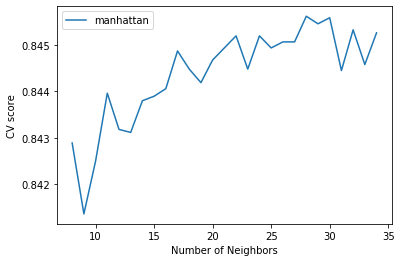

In [115]:
knn_results = pd.DataFrame(cv_scores, index=range(*k_range))
knn_results.plot(xlabel='Number of Neighbors', ylabel='CV score')

p=1, k=17: acc=0.8542500661429502

In [150]:
p_value = 1
k_value = 17
knn_clf = KNeighborsClassifier(k_value, p = p_value)
score = np.mean(cross_val_score(knn_clf, X_train, Y_train, cv=10))
print(f'p={p_value}, k={k_value}: acc={score}')

knn_clf.fit(X_train, Y_train)

p=1, k=17: acc=0.8542500661429502


KNeighborsClassifier(n_neighbors=17, p=1)

manhattan with 34 neighbors: 0.8523944277956421

In [153]:
Y_hat_test = knn_clf.predict(X_test)
Y_hat_test = label_encoder.inverse_transform(Y_hat_test)

In [157]:
result_data = pd.DataFrame({'income': Y_hat_test})
result_data.to_csv('submission.csv', index = True, index_label = 'Id')

NameError: name 'result' is not defined